# Regression
Features = rates from selected diseases (FeatureSelection) + suicide rate 

Target = suicide rate of the following year

Import libraries

In [17]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import glob
root = "../../"

In [18]:
dict_uf_cod = {11: 'RO',
12: 'AC',
13: 'AM',
14: 'RR',
15: 'PA',
16: 'AP',
17: 'TO',
21: 'MA',
22: 'PI',
23: 'CE',
24: 'RN',
25: 'PB',
26: 'PE',
27: 'AL',
28: 'SE',
29: 'BA',
31: 'MG',
32: 'ES',
33: 'RJ',
35: 'SP',
41: 'PR',
42: 'SC',
43: 'RS',
50: 'MS',
51: 'MT',
52: 'GO',
53: 'DF'}

Prepare dataset

In [21]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
# all_files = all_files + glob.glob(path + "Groups/" + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = ["08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18"]

final_df = pd.DataFrame()

for i in range(len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev,col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for file in all_files:
        file_name = file.split("/")[-1]
        disease = file_name.split(".csv")[0]

        disease_df = pd.read_csv(file, sep=',', index_col=0)
        disease_df = disease_df[[col_year_prev, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_prev: disease})
        
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    
#     year_df = year_df.drop("MUNCOD", axis=1)
    final_df = pd.concat([final_df, year_df])
    

# final_df = final_df.drop("MUNCOD", axis=1)
final_df = final_df[(final_df["RATE"] > 0) | (final_df["PREVIOUS"] > 0)]
final_df

,DIFTERIA,MUNCOD,NEOPLASIA_MALIGNA_DO_ESTÔMAGO,FRATURA_DO_CRÂNIO_E_DOS_OSSOS_DA_FACE,DOENÇA_DE_HODGKIN,OUTRAS_DOENÇAS_CEREBROVASCULARES,FEBRES_RECORRENTES,ESTADO_INFEC_ASSINT_VÍRUS_DA_IMUNODEF_HUMANA_[HIV],PNEUMOCONIOSE,NEOPLASIA_MALIGNA_DA_PRÓSTATA,...,ASMA,CERATITE_E_OUTROS_TRANSTORNOS_ESCLERÓTICA_E_CÓRNEA,INFECÇÕES_PELO_VÍRUS_DO_HERPES,NEOPLASIA_MALIGNA_DO_LÁBIO_CAVIDADE_ORAL_E_FARINGE,TUBERCULOSE_PULMONAR,AUSÊNCIA_ATRESIA_E_ESTENOSE_DO_INTESTINO_DELGADO,OUTRAS_DOENÇAS_DO_APARELHO_DIGESTIVO,OUTRAS_TUBERCULOSES_RESPIRATÓRIAS,PREVIOUS,RATE
0,0.000000,110001,0.000000,16.275379,0.000000,0.000000,0.0,NaN,NaN,0.000000,...,752.736298,0.000000,0.000000,0.000000,0.000000,NaN,28.481914,0.000000,20.344224,8.212203
1,0.000000,110009,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,...,66.394101,0.000000,0.000000,0.000000,0.000000,NaN,52.416396,NaN,0.000000,6.922331
2,0.000000,110020,4.483288,4.219565,1.318614,2.637228,0.0,NaN,0.000000,3.692119,...,30.591847,5.274456,3.428397,2.373505,0.527446,0.0,11.603804,10.021467,4.483288,5.485478
5,0.000000,120020,9.163263,53.670541,0.000000,0.000000,0.0,NaN,0.000000,3.927113,...,261.807519,1.309038,1.309038,3.927113,26.180752,0.0,71.997068,1.309038,5.236150,9.090437
7,0.331787,120040,5.308595,10.948978,0.000000,3.981446,0.0,NaN,0.331787,4.645021,...,14.930424,2.654298,0.663574,6.635744,11.612552,0.0,65.362079,5.640382,5.972170,6.536930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,NaN,521839,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,29.761905,...,0.000000,0.000000,NaN,29.761905,0.000000,NaN,119.047619,0.000000,0.000000,61.671292
5374,NaN,521935,NaN,25.926886,NaN,0.000000,NaN,NaN,NaN,0.000000,...,51.853772,0.000000,NaN,0.000000,NaN,NaN,51.853772,103.707545,0.000000,26.295030
5376,NaN,522068,NaN,14.511682,NaN,0.000000,NaN,NaN,NaN,0.000000,...,87.070091,NaN,NaN,0.000000,14.511682,NaN,0.000000,0.000000,14.511682,0.000000
5377,NaN,522157,NaN,0.000000,33.772374,0.000000,NaN,NaN,NaN,0.000000,...,0.000000,NaN,NaN,0.000000,NaN,NaN,67.544748,0.000000,0.000000,34.867503


In [22]:
final_df['UF'] = final_df['MUNCOD'] / 10000
final_df['UF'] = final_df['UF'].astype(int)
final_df['UF'].replace(dict_uf_cod, inplace=True)
final_df

,DIFTERIA,MUNCOD,NEOPLASIA_MALIGNA_DO_ESTÔMAGO,FRATURA_DO_CRÂNIO_E_DOS_OSSOS_DA_FACE,DOENÇA_DE_HODGKIN,OUTRAS_DOENÇAS_CEREBROVASCULARES,FEBRES_RECORRENTES,ESTADO_INFEC_ASSINT_VÍRUS_DA_IMUNODEF_HUMANA_[HIV],PNEUMOCONIOSE,NEOPLASIA_MALIGNA_DA_PRÓSTATA,...,CERATITE_E_OUTROS_TRANSTORNOS_ESCLERÓTICA_E_CÓRNEA,INFECÇÕES_PELO_VÍRUS_DO_HERPES,NEOPLASIA_MALIGNA_DO_LÁBIO_CAVIDADE_ORAL_E_FARINGE,TUBERCULOSE_PULMONAR,AUSÊNCIA_ATRESIA_E_ESTENOSE_DO_INTESTINO_DELGADO,OUTRAS_DOENÇAS_DO_APARELHO_DIGESTIVO,OUTRAS_TUBERCULOSES_RESPIRATÓRIAS,PREVIOUS,RATE,UF
0,0.000000,110001,0.000000,16.275379,0.000000,0.000000,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,28.481914,0.000000,20.344224,8.212203,RO
1,0.000000,110009,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,52.416396,NaN,0.000000,6.922331,RO
2,0.000000,110020,4.483288,4.219565,1.318614,2.637228,0.0,NaN,0.000000,3.692119,...,5.274456,3.428397,2.373505,0.527446,0.0,11.603804,10.021467,4.483288,5.485478,RO
5,0.000000,120020,9.163263,53.670541,0.000000,0.000000,0.0,NaN,0.000000,3.927113,...,1.309038,1.309038,3.927113,26.180752,0.0,71.997068,1.309038,5.236150,9.090437,AC
7,0.331787,120040,5.308595,10.948978,0.000000,3.981446,0.0,NaN,0.331787,4.645021,...,2.654298,0.663574,6.635744,11.612552,0.0,65.362079,5.640382,5.972170,6.536930,AC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,NaN,521839,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,29.761905,...,0.000000,NaN,29.761905,0.000000,NaN,119.047619,0.000000,0.000000,61.671292,GO
5374,NaN,521935,NaN,25.926886,NaN,0.000000,NaN,NaN,NaN,0.000000,...,0.000000,NaN,0.000000,NaN,NaN,51.853772,103.707545,0.000000,26.295030,GO
5376,NaN,522068,NaN,14.511682,NaN,0.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,0.000000,14.511682,NaN,0.000000,0.000000,14.511682,0.000000,GO
5377,NaN,522157,NaN,0.000000,33.772374,0.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,0.000000,NaN,NaN,67.544748,0.000000,0.000000,34.867503,GO


In [23]:
dummy = pd.get_dummies(final_df['UF'])
final_dummy_df = pd.concat([final_df, dummy], axis=1)
final_dummy_df = final_dummy_df.drop(['MUNCOD', 'UF'], axis=1)
final_dummy_df

,DIFTERIA,NEOPLASIA_MALIGNA_DO_ESTÔMAGO,FRATURA_DO_CRÂNIO_E_DOS_OSSOS_DA_FACE,DOENÇA_DE_HODGKIN,OUTRAS_DOENÇAS_CEREBROVASCULARES,FEBRES_RECORRENTES,ESTADO_INFEC_ASSINT_VÍRUS_DA_IMUNODEF_HUMANA_[HIV],PNEUMOCONIOSE,NEOPLASIA_MALIGNA_DA_PRÓSTATA,OUTRAS_NEOPL_MALIG_ÓRG_RESPIRAT_E_INTRATORÁCICOS,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0.000000,0.000000,16.275379,0.000000,0.000000,0.0,NaN,NaN,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,4.483288,4.219565,1.318614,2.637228,0.0,NaN,0.000000,3.692119,0.263723,...,0,0,0,1,0,0,0,0,0,0
5,0.000000,9.163263,53.670541,0.000000,0.000000,0.0,NaN,0.000000,3.927113,1.309038,...,0,0,0,0,0,0,0,0,0,0
7,0.331787,5.308595,10.948978,0.000000,3.981446,0.0,NaN,0.331787,4.645021,5.308595,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,29.761905,NaN,...,0,0,0,0,0,0,0,0,0,0
5374,NaN,NaN,25.926886,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
5376,NaN,NaN,14.511682,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
5377,NaN,NaN,0.000000,33.772374,0.000000,NaN,NaN,NaN,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0


In [24]:
final_dummy_df.shape

(38331, 342)

Define X and y

In [86]:
percentage_valid_values = 0.8
N = int(final_dummy_df.shape[1]*percentage_valid_values)
print(N)
final_zeros_df = final_dummy_df.dropna(thresh=N) # At least N non null items

X = final_zeros_df.drop(columns="RATE")
X = X.fillna(0)
y = final_zeros_df["RATE"]

num_feat = 20
corr_min_value = 0.1
X.shape

273


(11473, 341)

Split data into train and test sets

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [88]:
X_train

,DIFTERIA,NEOPLASIA_MALIGNA_DO_ESTÔMAGO,FRATURA_DO_CRÂNIO_E_DOS_OSSOS_DA_FACE,DOENÇA_DE_HODGKIN,OUTRAS_DOENÇAS_CEREBROVASCULARES,FEBRES_RECORRENTES,ESTADO_INFEC_ASSINT_VÍRUS_DA_IMUNODEF_HUMANA_[HIV],PNEUMOCONIOSE,NEOPLASIA_MALIGNA_DA_PRÓSTATA,OUTRAS_NEOPL_MALIG_ÓRG_RESPIRAT_E_INTRATORÁCICOS,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
326,1.725596,3.451192,17.255958,0.000000,3.451192,0.000000,0.0,0.0,1.725596,0.000000,...,0,0,0,0,0,0,0,0,1,0
411,0.000000,6.547502,13.095004,0.000000,6.547502,0.000000,0.0,0.0,6.547502,0.000000,...,1,0,0,0,0,0,0,0,0,0
4880,0.000000,0.000000,15.019525,5.006508,5.006508,20.026034,0.0,0.0,35.045559,0.000000,...,0,0,0,0,0,0,0,0,0,0
4407,0.000000,0.000000,5.665241,0.000000,8.497861,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2284,0.000000,14.973142,5.614928,13.101499,0.000000,0.000000,0.0,0.0,18.716427,3.743285,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.000000,47.842728,26.096033,8.698678,8.698678,0.000000,0.0,0.0,26.096033,0.000000,...,1,0,0,0,0,0,0,0,0,0
2942,0.000000,12.260121,18.067547,0.645270,5.807426,0.000000,0.0,0.0,16.131738,3.226348,...,0,0,0,0,0,0,0,0,0,0
3649,0.000000,8.192692,11.469769,0.000000,3.277077,0.000000,0.0,0.0,8.192692,0.000000,...,0,0,0,0,0,0,0,0,1,0
3685,0.000000,4.850507,13.096370,1.455152,4.365457,0.000000,0.0,0.0,6.790710,1.455152,...,0,0,0,0,0,0,0,0,1,0


## Feature Selection

In [89]:
def cor_feature_selector(X,y,n):
    cor_list = []
    for i in list(X.columns):
        cor = np.corrcoef(X[i], y)[0,1]
        cor_list.append([i, cor])
    cor_ranking = sorted(cor_list, key=lambda a : abs(a[1]),reverse=True)
    cor_feature = [x[0] for x in cor_ranking[:n]]
    cor_support = [True if i in cor_feature else False for i in X.columns]
    return cor_support, cor_feature, cor_ranking
cor_support, cor_feature, cor_ranking = cor_feature_selector(X_train,y_train,num_feat)
print(str(len(cor_feature)), 'selected features')
print(cor_feature)

20 selected features
['PREVIOUS', 'RS', 'NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES', 'BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC', 'TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT', 'TRANSTORNOS_DE_HUMOR_[AFETIVOS]', 'NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC', 'DOENÇAS_DO_APÊNDICE', 'COLELITÍASE_E_COLECISTITE', 'OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE', 'TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL', 'TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS', 'FLEBITE_TROMBOFLEBITE_EMBOLIA_E_TROMBOSE_VENOSA', 'NEOPLASIA_MALIGNA_DO_CÓLON', 'PARTO_ÚNICO_ESPONTÂNEO', 'INSUFICIÊNCIA_RENAL', 'INFARTO_AGUDO_DO_MIOCÁRDIO', 'NEOPLASIA_MALIGNA_DO_PÂNCREAS', 'EMBOLIA_E_TROMBOSE_ARTERIAIS', 'FRATURA_DO_FÊMUR']


In [90]:
cor_ranking_filtered = list(filter(lambda a: abs(a[1]) > corr_min_value, cor_ranking))
diseases_filtered = [d[0] for d in cor_ranking_filtered]
X_train = X_train[diseases_filtered]
X_test = X_test[diseases_filtered]
cor_support = [True if i in cor_feature else False for i in X_train.columns]
X_train.shape

(7686, 51)

In [91]:
cor_ranking

[['PREVIOUS', 0.313512651028471],
 ['RS', 0.24426348506293816],
 ['NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES', 0.2238726364557061],
 ['BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC', 0.22024057054568316],
 ['TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT', 0.20848606078761203],
 ['TRANSTORNOS_DE_HUMOR_[AFETIVOS]', 0.20254331832809294],
 ['NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC', 0.19745136777815783],
 ['DOENÇAS_DO_APÊNDICE', 0.19656373312613779],
 ['COLELITÍASE_E_COLECISTITE', 0.19180614017889666],
 ['OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE', 0.1818274215505064],
 ['TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL', 0.17675234927659703],
 ['TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS', 0.17110348954042617],
 ['FLEBITE_TROMBOFLEBITE_EMBOLIA_E_TROMBOSE_VENOSA', 0.16211823671395928],
 ['NEOPLASIA_MALIGNA_DO_CÓLON', 0.15912013575067227],
 ['PARTO_ÚNICO_ESPONTÂNEO', -0.15716376273016572],
 ['INSUFICIÊNCIA_RENAL', 0.15714580704934777],
 ['INFARTO_AGUDO_DO_MIOCÁRDIO'

### RFE

In [92]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
rfe_selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=num_feat, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 51 features.
Fitting estimator with 41 features.
Fitting estimator with 31 features.
Fitting estimator with 21 features.
20 selected features
['PREVIOUS', 'NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES', 'BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC', 'TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT', 'NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC', 'DOENÇAS_DO_APÊNDICE', 'COLELITÍASE_E_COLECISTITE', 'OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE', 'TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS', 'NEOPLASIA_MALIGNA_DO_CÓLON', 'PARTO_ÚNICO_ESPONTÂNEO', 'INSUFICIÊNCIA_RENAL', 'INFARTO_AGUDO_DO_MIOCÁRDIO', 'OUTRAS_DOENÇAS_DOS_INTESTINOS_E_PERITÔNIO', 'PNEUMONIA', 'OUTRAS_DOENÇAS_DO_APARELHO_DIGESTIVO', 'LUXAÇÕES_ENTORSE_DISTENSÃO_REG_ESP_E_MÚLTIP_CORPO', 'OUTROS_TRANSTRONOS_ARTICULARES', 'NEOPLASIA_MALIGNA_DA_MAMA', 'CERT_COMPL_PREC_TRAUM_COMPL_CIRÚRG_ASS_MÉDIC_NCOP']


### SelectFromModel

In [93]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

embeded_rf_selector = SelectFromModel(RandomForestRegressor())
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

18 selected features
['PREVIOUS', 'NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES', 'BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC', 'NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC', 'DOENÇAS_DO_APÊNDICE', 'COLELITÍASE_E_COLECISTITE', 'OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE', 'TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS', 'NEOPLASIA_MALIGNA_DO_CÓLON', 'PARTO_ÚNICO_ESPONTÂNEO', 'INSUFICIÊNCIA_RENAL', 'OUTRAS_DOENÇAS_DOS_INTESTINOS_E_PERITÔNIO', 'OUTRAS_DOENÇAS_DO_APARELHO_DIGESTIVO', 'LUXAÇÕES_ENTORSE_DISTENSÃO_REG_ESP_E_MÚLTIP_CORPO', 'OUTROS_TRANSTRONOS_ARTICULARES', 'INSUFICIÊNCIA_CARDÍACA', 'NEOPLASIA_MALIGNA_DA_MAMA', 'CERT_COMPL_PREC_TRAUM_COMPL_CIRÚRG_ASS_MÉDIC_NCOP']


In [94]:
feature_selection_df = pd.DataFrame({'Feature':X_train.columns, 'Pearson':cor_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feat)

,Feature,Pearson,RFE,Random Forest,Total
1,TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS,True,True,True,3
2,PREVIOUS,True,True,True,3
3,PARTO_ÚNICO_ESPONTÂNEO,True,True,True,3
4,OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE,True,True,True,3
5,NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_E...,True,True,True,3
6,NEOPLASIA_MALIGNA_DO_CÓLON,True,True,True,3
7,NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES,True,True,True,3
8,INSUFICIÊNCIA_RENAL,True,True,True,3
9,DOENÇAS_DO_APÊNDICE,True,True,True,3
10,COLELITÍASE_E_COLECISTITE,True,True,True,3


In [95]:
selected_diseases = feature_selection_df[feature_selection_df['Total'] == 3]['Feature']
selected_diseases

1         TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS
2                                              PREVIOUS
3                                PARTO_ÚNICO_ESPONTÂNEO
4                    OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE
5     NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_E...
6                            NEOPLASIA_MALIGNA_DO_CÓLON
7     NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES
8                                   INSUFICIÊNCIA_RENAL
9                                   DOENÇAS_DO_APÊNDICE
10                            COLELITÍASE_E_COLECISTITE
11    BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC
Name: Feature, dtype: object

In [96]:
# Using only RFE
X_train = X_train[rfe_feature]
X_test = X_test[rfe_feature]

## Model

In [97]:
# Bayesian Optimization
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]
    
    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33)
    
    model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    
    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)
    
    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))

space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]

from skopt import gp_minimize

resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

In [98]:
resultado_gp.x

[1000, 29, 61, 0.7883700664684228]

Fit the RandomForest regression model

In [99]:
regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                                  max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=29, max_features=0.7883700664684228,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=61, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Calculate metrics corresponding to the regression model

In [100]:
def calcMetrics(y_train, y_pred_train, y_test, y_pred):
    print("Root Mean Squared Error Train: " + str(np.sqrt(metrics.mean_squared_error(y_pred_train,y_train))))
    print("Root Mean Squared Error Test: " + str(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
    #print("MAPE Test: " + str(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))
def calcUpMetrics(y_pred,y_test,X_test):
    up_df = pd.DataFrame({"Pred": y_pred, "Real": y_test, "Previous": X_test["PREVIOUS"]})
    up_df["UP"] = up_df["Previous"] < up_df["Real"]
    up_df["UP_PRED"] = up_df["Previous"] < up_df["Pred"]
    up_df["UP"] = up_df["UP"].astype(int)
    up_df["UP_PRED"] = up_df["UP_PRED"].astype(int)
    print("Accuracy UP/DOWN: ", metrics.accuracy_score(up_df["UP"], up_df["UP_PRED"]))

In [101]:
y_pred = regressor.predict(X_test) 
y_pred_train = regressor.predict(X_train)
print("# Regression Model")
calcMetrics(y_train, y_pred_train, y_test, y_pred)
calcUpMetrics(y_pred,y_test,X_test)

# Regression Model
Root Mean Squared Error Train: 4.243809291195869
Root Mean Squared Error Test: 4.558117973506886
Accuracy UP/DOWN:  0.6868233430155796


We also define a baseline model consisting of predicting the previous year suicide rate

# Regression Model 100
Root Mean Squared Error Train: 4.343622983880137
Root Mean Squared Error Test: 4.570277304414776
Accuracy UP/DOWN:  0.6847108529178769

# Regression Model 50
Root Mean Squared Error Train: 4.353947034575768
Root Mean Squared Error Test: 4.569606917229303
Accuracy UP/DOWN:  0.6849749141800898


In [102]:
y_pred = X_test["PREVIOUS"]
y_pred_train = X_train["PREVIOUS"]
print("# Baseline Model")
calcMetrics(y_train, y_pred_train, y_test, y_pred)
calcUpMetrics(y_pred,y_test,X_test)

# Baseline Model
Root Mean Squared Error Train: 5.767578282843047
Root Mean Squared Error Test: 5.621655517806497
Accuracy UP/DOWN:  0.532347504621072


K-fold cross validation

In [103]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

rmse_regression = []
rmse_baseline = []
accuracy_up_down = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                                  max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])

    regressor.fit(X_train,y_train)
    
    rmse_regression.append(
        np.sqrt(metrics.mean_squared_error(regressor.predict(X_test),y_test))
    )
    
    up_df = pd.DataFrame({"Pred": regressor.predict(X_test), "Real": y_test, "Previous": X_test["PREVIOUS"]})
    up_df["UP"] = up_df["Previous"] < up_df["Real"]
    up_df["UP_PRED"] = up_df["Previous"] < up_df["Pred"]
    up_df["UP"] = up_df["UP"].astype(int)
    up_df["UP_PRED"] = up_df["UP_PRED"].astype(int)
    accuracy_up_down.append(metrics.accuracy_score(up_df["UP"], up_df["UP_PRED"]))
    
    rmse_baseline.append(
        np.sqrt(metrics.mean_squared_error(X_test["PREVIOUS"],y_test))
    )
    
print("Mean RMSE for the regression model was:", np.mean(rmse_regression))
print("Mean accuracy (up/down) for the regression model was:", np.mean(accuracy_up_down))
print("Mean RMSE for the baseline model was:", np.mean(rmse_baseline))

Mean RMSE for the regression model was: 4.43973573676485
Mean accuracy (up/down) for the regression model was: 0.6911880983319503
Mean RMSE for the baseline model was: 5.71433472212092


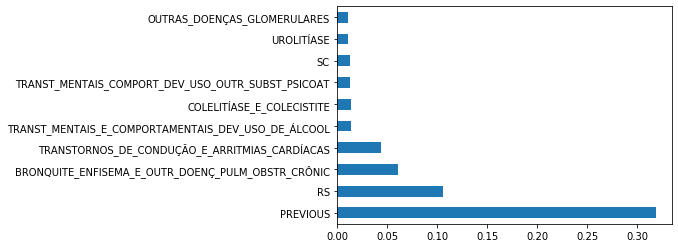

,Feature,Importance
313,PREVIOUS,0.318706
336,RS,0.106208
291,BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC,0.061113
78,TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS,0.044127
279,TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁL...,0.014044
37,COLELITÍASE_E_COLECISTITE,0.013694
19,TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT,0.013466
337,SC,0.012838
49,UROLITÍASE,0.010835
27,OUTRAS_DOENÇAS_GLOMERULARES,0.010617


In [104]:
import matplotlib.pyplot as plt
importance = regressor.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False)
feature_importance_pd = pd.Series(importance, index=X_train.columns)

feature_importance_pd.nlargest(10).plot(kind='barh')
plt.show()
feature_importance_df.head(10)


In [62]:
import seaborn as sns

data = final_zeros_df.fillna(0)


corrmat = data[rfe_feature + ["RATE"]].corr()
corrmat['RATE'].sort_values(ascending=False)
# plt.figure(figsize=(40,40))
# #plot heat map
# g=sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

RATE                                                  1.000000
PREVIOUS                                              0.336807
RS                                                    0.263352
NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES     0.226617
TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT     0.222143
BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC     0.221627
DOENÇAS_DO_APÊNDICE                                   0.209810
NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC    0.197393
COLELITÍASE_E_COLECISTITE                             0.194794
FLEBITE_TROMBOFLEBITE_EMBOLIA_E_TROMBOSE_VENOSA       0.177806
TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS         0.176623
OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE                    0.173564
NEOPLASIA_MALIGNA_DO_CÓLON                            0.162600
NEOPLASIA_MALIGNA_DO_PÂNCREAS                         0.157349
INSUFICIÊNCIA_RENAL                                   0.157093
INFARTO_AGUDO_DO_MIOCÁRDIO                            0

In [63]:
cor_ranking

[['PREVIOUS', 0.313512651028471],
 ['RS', 0.24426348506293816],
 ['NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES', 0.2238726364557061],
 ['BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC', 0.22024057054568316],
 ['TRANST_MENTAIS_COMPORT_DEV_USO_OUTR_SUBST_PSICOAT', 0.20848606078761203],
 ['TRANSTORNOS_DE_HUMOR_[AFETIVOS]', 0.20254331832809294],
 ['NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_ESPEC', 0.19745136777815783],
 ['DOENÇAS_DO_APÊNDICE', 0.19656373312613779],
 ['COLELITÍASE_E_COLECISTITE', 0.19180614017889666],
 ['OUTRAS_NEOPLASIAS_MALIGNAS_DA_PELE', 0.1818274215505064],
 ['TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁLCOOL', 0.17675234927659703],
 ['TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACAS', 0.17110348954042617],
 ['FLEBITE_TROMBOFLEBITE_EMBOLIA_E_TROMBOSE_VENOSA', 0.16211823671395928],
 ['NEOPLASIA_MALIGNA_DO_CÓLON', 0.15912013575067227],
 ['PARTO_ÚNICO_ESPONTÂNEO', -0.15716376273016572],
 ['INSUFICIÊNCIA_RENAL', 0.15714580704934777],
 ['INFARTO_AGUDO_DO_MIOCÁRDIO'